> Resnet Implementation on EEG Distance Learning Dataset




In [ ]:
%%capture
!pip install ssqueezepy  #To convert our signal into an image to use 2D Convolution Layer
!pip install timm  #For pytorch models
!pip install pytorch-lightning

In [ ]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau,CosineAnnealingWarmRestarts,OneCycleLR,CosineAnnealingLR
import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score,roc_curve,auc,roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import DataLoader, Dataset,ConcatDataset
import torchmetrics
import timm
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/My Drive/

/content/gdrive/My Drive


>  EEG Distance Learning Channels






In [ ]:
import pandas as pd
import os
df=pd.read_csv('EEG_data.csv')
df.head() #Contains video and subject idea pertaining to a specific video watched by a specific student

,video_id,subject_id,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,...,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,subject_understood
0,0,0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,...,1.583895,0.504567,0.471979,0.138717,1.801014,1.504794,0.258570,0.435745,0.469483,0
1,0,0,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,...,1.709560,0.606587,0.527616,0.155580,1.859177,1.379617,0.317579,0.468416,0.642560,0
2,0,0,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,...,1.873591,0.795834,0.565414,0.170816,2.027946,1.283876,0.441925,0.494701,0.798197,0
3,0,0,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,...,2.110017,1.021118,0.579656,0.180056,2.265952,1.306188,0.616881,0.506062,0.886495,0
4,0,0,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,...,2.462552,1.230984,0.573620,0.181081,2.461205,1.522420,0.822598,0.498361,0.874455,0


> Data preprocessing



In [ ]:
cols_remove=df.columns.tolist()[16:-1] #We need the first 16 channels to get raw data of 14 channels
df=df.loc[:, ~df.columns.isin(cols_remove)]
df.columns = df.columns.str.strip('EEG.')
df.head()
df['subject_understood'].unique() #This is the target(whether the student has understood the lecture on not)

#Creating groups for each student
groups=df.groupby(['subject_id','video_id'])
grp_keys=list(groups.groups.keys())
print(grp_keys)
grpno=grp_keys[0]
grp1=groups.get_group(grpno).drop(['subject_id','video_id'],axis=1)
label=grp1['subject_understood']
subject_id=grpno[0]
grp1=grp1.drop('subject_understood',axis=1)
grp1.head()

[(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (7, 10)]


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4210.641113,4179.102539,4287.948730,4235.384766,4207.948730,4165.000000,4135.897461,4170.000000,4155.384766,4157.179688,4610.384766,4388.846191,4413.461426,4499.743652
1,4201.025879,4188.717773,4280.128418,4236.922852,4209.615234,4152.436035,4130.128418,4149.487305,4149.487305,4157.820313,4583.717773,4376.666504,4392.820313,4488.461426
2,4203.205078,4182.820313,4282.820313,4231.025879,4207.820313,4172.436035,4131.538574,4147.948730,4131.666504,4131.666504,4574.743652,4377.051270,4390.512695,4483.077148
3,4186.538574,4168.717773,4266.794922,4229.230957,4202.179688,4155.384766,4128.333496,4151.666504,4136.666504,4134.230957,4565.512695,4362.436035,4380.897461,4471.025879
4,4232.436035,4216.922852,4306.922852,4270.769043,4217.436035,4166.538574,4155.897461,4162.820313,4143.461426,4154.487305,4612.436035,4403.333496,4410.641113,4512.179688


In [ ]:
%%capture
!pip install mne

In [ ]:
import mne

> Converting the data into MNE format



In [ ]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128) #Adding "EEG" to the channel names
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference() #Normalize the data in the channels
    epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=2)
    return epochs.get_data()  #Convert data from MNE format into a numpy format

In [ ]:
test=convertDF2MNE(grp1)
test.shape #(Number of epochs* Number of channels* Length of each epoch)

Creating RawArray with float64 data, n_channels=14, n_times=2402
    Range : 0 ... 2401 =      0.000 ...    18.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 384 original time points ...
0 bad epochs dropped


(16, 14, 384)


> Scaleogram plot- Using Continuous Wavelet Transform from ssqueezepy



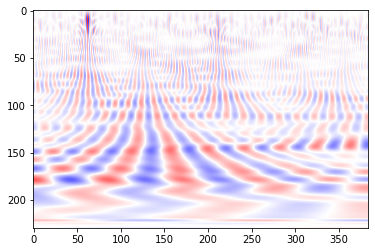

Creating RawArray with float64 data, n_channels=14, n_times=2402
    Range : 0 ... 2401 =      0.000 ...    18.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 384 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=2402
    Range : 0 ... 2401 =      0.000 ...    18.758 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16 events and 384 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=2389
    Range : 0 ... 2388 =      0.000 ...    18.656 s

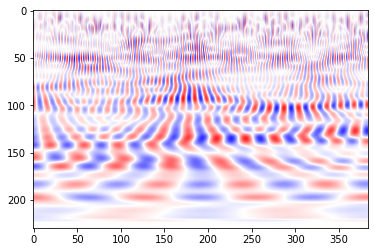

,path,label,group
0,"./scaleogram/subvideo_(0, 0)/trial_0.npy",0,0
1,"./scaleogram/subvideo_(0, 0)/trial_1.npy",0,0
2,"./scaleogram/subvideo_(0, 0)/trial_2.npy",0,0
3,"./scaleogram/subvideo_(0, 0)/trial_3.npy",0,0
4,"./scaleogram/subvideo_(0, 0)/trial_4.npy",0,0


In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import os
import re
import pandas as pd
test[0][0].shape
Wx, scales = cwt(test[0], 'morlet')
Wx.shape
imshow(Wx[0])
#%%capture
grpnos,labels,paths=[],[],[]
for i,grpno in enumerate(grp_keys):
    grp=groups.get_group(grpno).drop(['subject_id','video_id'],axis=1)
    label=int(grp['subject_understood'].unique())
    subject_id=grpno[0]
    grp=grp.drop('subject_understood',axis=1)
    data=convertDF2MNE(grp)#(trials, channels, length)
    for c,x in enumerate(data):#loop trials
        Wx, scales = cwt(x, 'morlet')
        Wx=np.abs(Wx)
        path=os.path.join('./scaleogram',f'subvideo_{grpno}/',)
        os.makedirs(path,exist_ok=True)
        path=path+f'trial_{c}.npy'
        np.save(path,Wx)

        grpnos.append(i)
        labels.append(label)
        paths.append(path)
Wx, scales = cwt(x, 'morlet')
imshow(Wx[0])
df_scale=pd.DataFrame(zip(paths,labels,grpnos),columns=['path','label','group'])
df_scale.head()



> ResNet Model





In [ ]:
#read data from folders
class DataReader(Dataset):
    def __init__(self, dataset,aug=None):
        self.dataset = dataset
        self.aug=aug
    def __getitem__(self, index):
        x=self.dataset.path[index]
        y=self.dataset.label[index]
        x=np.load(x)
        if self.aug:
          if random.uniform(0, 1)>0.5:
            x=np.flip(x,-1)
          if random.uniform(0, 1)>0.5:
            x=np.flip(x,-2)
        x=(x - np.min(x)) / (np.max(x) - np.min(x))

        return x, y

    def __len__(self):
        return len(self.dataset)
test_loader=DataLoader(DataReader(df_scale,True), batch_size =8)
test_batch=next(iter(test_loader))
test_batch[0].shape ,test_batch[1].shape
import timm
class OurModel(LightningModule):
    def __init__(self,train_split,val_split):
        super(OurModel,self).__init__()
        self.train_split=train_split
        self.val_split=val_split
        model_name='resnest26d'
        self.model =  timm.create_model(model_name,pretrained=True)
        self.model.conv1[0]=nn.Conv2d(14, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,250)
        self.fc3= nn.Linear(250,1)
        self.drp=nn.Dropout(0.25)
        #parameters
        self.lr=1e-3
        self.batch_size=16
        self.numworker=2
        self.criterion=nn.BCEWithLogitsLoss()
        self.metrics=torchmetrics.Accuracy()

        self.trainloss,self.valloss=[],[]
        self.trainacc,self.valacc=[],[]

        self.sub_pred=0
    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drp(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.drp(x)
        x=self.fc3(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt

    def train_dataloader(self):
        return DataLoader(DataReader(self.train_split,False), batch_size = self.batch_size,
                          num_workers=self.numworker,pin_memory=True,shuffle=True)

    def training_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)
        loss=self.criterion(pred.flatten(),label.float()) #calculate loss
        acc=self.metrics(pred.flatten(),label)#calculate accuracy
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainloss.append(loss)
        self.trainacc.append(acc)
        self.log('train_loss', loss)

    def val_dataloader(self):
        ds=DataLoader(DataReader(self.val_split), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True, shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)
        loss=self.criterion(pred.flatten(),label.float()) #calculate loss
        acc=self.metrics(pred.flatten(),label)#calculate accuracy
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valloss.append(loss)
        self.valacc.append(acc)
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_dataloader(self):
        ds=DataLoader(DataReader(self.val_split), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True, shuffle=False)
        return ds
    def test_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)

        return {'label':label,'pred':pred}

    def test_epoch_end(self, outputs):

        label=torch.cat([x["label"] for x in outputs])
        pred=torch.cat([x["pred"] for x in outputs])
        acc=self.metrics(pred.flatten(),label)
        pred=pred.detach().cpu().numpy().ravel()
        label=label.detach().cpu().numpy().ravel()
        print('sklearn auc',roc_auc_score(label,pred))
        pred=np.where(pred>0.5,1,0).astype(int)
        print('torch acc',acc)
        print(classification_report(label,pred))
        print('sklearn',accuracy_score(label,pred))

In [ ]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut,StratifiedGroupKFold
gkf=StratifiedGroupKFold(5)
result=[]
valacc=[]
for train_index, val_index in gkf.split(df_scale.path,df_scale.label,  groups=df_scale.group):
    train_df=df_scale.iloc[train_index].reset_index(drop=True)
    val_df=df_scale.iloc[val_index].reset_index(drop=True)


    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    gpu=-1 if torch.cuda.is_available() else 0
    gpup=16 if torch.cuda.is_available() else 32
    model=OurModel(train_df,val_df)
    trainer = Trainer(max_epochs=20, auto_lr_find=True, auto_scale_batch_size=True,
                        deterministic=True,
                        gpus=gpu,precision=gpup,
                        accumulate_grad_batches=2,
                        enable_progress_bar = True,
                        num_sanity_val_steps=0,
                        callbacks=[lr_monitor],

                        )
    trainer.fit(model)
    res=trainer.validate(model)
    result.append(res)
    valacc.append(model.valacc)
    trainer.test(model)


val_df.label.unique(),val_df.group.unique()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.6499999761581421
        val_loss             7.369999885559082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

sklearn auc 0.632973944294699
torch acc tensor(0.6421, device='cuda:0')
              precision    recall  f1-score   support

           0       0.76      0.53      0.62        53
           1       0.57      0.79      0.66        42

    accuracy                           0.64        95
   macro avg       0.66      0.66      0.64        95
weighted avg       0.67      0.64      0.64        95

sklearn 0.6421052631578947


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | m

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.3799999952316284
        val_loss            2.3299999237060547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

sklearn auc 0.3058510638297872
torch acc tensor(0.3810, device='cuda:0')
              precision    recall  f1-score   support

           0       0.15      0.31      0.20        16
           1       0.63      0.40      0.49        47

    accuracy                           0.38        63
   macro avg       0.39      0.36      0.35        63
weighted avg       0.51      0.38      0.42        63

sklearn 0.38095238095238093


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | m

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7699999809265137
        val_loss             2.549999952316284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

sklearn auc 0.5973011363636364
torch acc tensor(0.7500, device='cuda:0')
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        16
           1       0.75      0.98      0.85        44

    accuracy                           0.75        60
   macro avg       0.71      0.55      0.53        60
weighted avg       0.73      0.75      0.68        60

sklearn 0.75


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | m

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8399999737739563
        val_loss            0.3199999928474426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

ValueError: ignored